In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlb
import warnings
warnings.filterwarnings('ignore')


In [11]:
df=pd.read_csv("C:/Users/mananshah/Desktop/Study/Datasets/portland-oregon-average-monthly-.csv")
df.head()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [12]:
print(df.shape)
print(df.columns)

(114, 2)
Index(['Month', 'Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114'], dtype='object')


In [13]:
df.columns=['Month','Monthly_Rides']
df.head()

,Month,Monthly_Rides
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [14]:
#convert the month to datetime format
df['Month']=pd.to_datetime(df['Month'])

In [15]:
#set month as the index
df.set_index('Month',inplace=True)
df.head()

,Monthly_Rides
Month,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


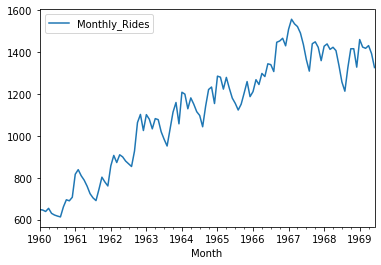

In [16]:
#plot the data
df.plot(kind='line')

<Figure size 432x288 with 0 Axes>

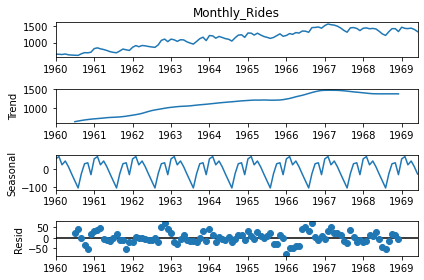

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.Monthly_Rides,freq=12)
fig=plt.figure()
fig=decomposition.plot()

In [28]:
def plot_timeseries(timeseries):
    #plot the mean and std_deviation for the window size of 12 months i.e. 1 year
    rol_std=timeseries.rolling(window=12).std()
    rol_mean=timeseries.rolling(window=12).mean()
    fig=plt.figure(figsize=(12,8))
    orig=plt.plot(timeseries,color='blue',label='orignal')
    mean=plt.plot(rol_mean,color='red',label='mean')
    std=plt.plot(rol_std,color='black',label='std deviation')
    plt.legend(loc='best')
    plt.xlabel('year')
    plt.ylabel('Rides')
    plt.show()

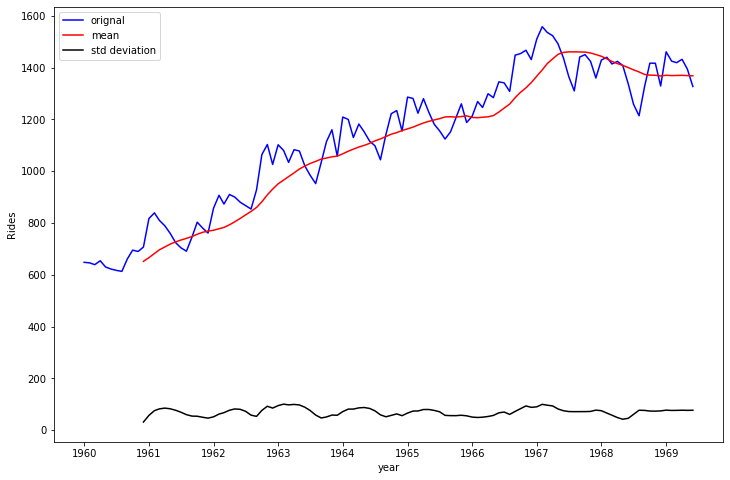

In [29]:
plot_timeseries(df)

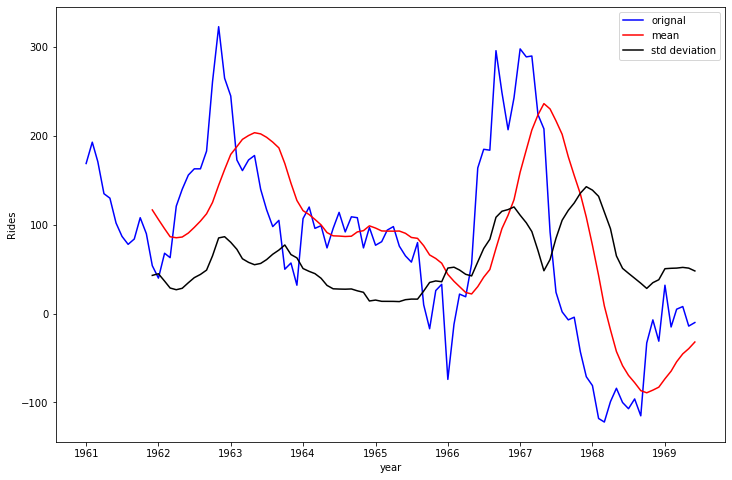

In [30]:
#plotting seasonal difference
df['season_difference']=df.Monthly_Rides - df.Monthly_Rides.shift(12)
plot_timeseries(df.season_difference)

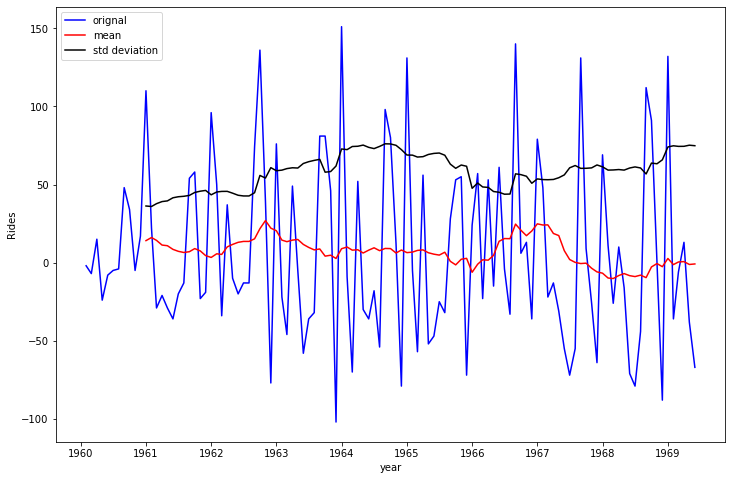

In [31]:
#plot the first difference
df['first_difference']=df.Monthly_Rides - df.Monthly_Rides.shift(1)
plot_timeseries(df.first_difference)

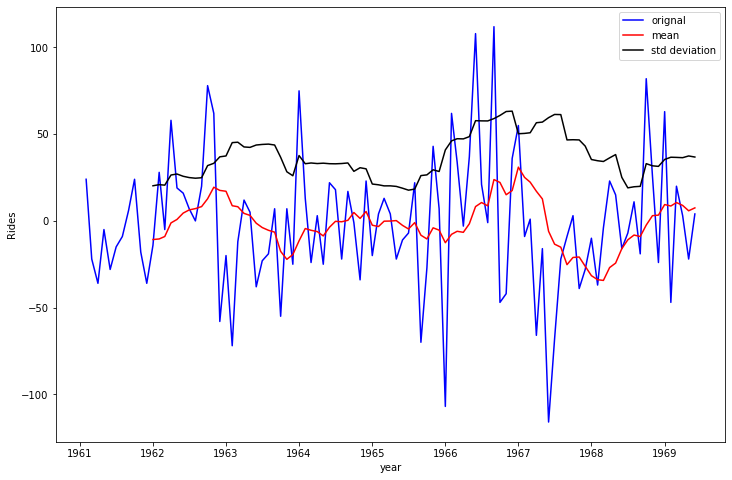

In [32]:
#plot the first seasonal difference
df['seasonal_first_difference']=df.first_difference - df.first_difference.shift(12)
plot_timeseries(df.seasonal_first_difference)

In [33]:
from statsmodels.tsa.stattools import adfuller

In [40]:
#perfom the dicky fuller test to check the stationarity
def dicky_fuller(timeseries):
    x=adfuller(timeseries,autolag='AIC')
    dfop=pd.Series(x[:4],index=['Test Statistic','p-value','#Lags','No.of.observations'])
    #print(x)
    for key,value in x[4].items():
        dfop['Critical value %s'%key]=value
    print(dfop)

In [41]:
# original monthly rides
dicky_fuller(df.Monthly_Rides)

Test Statistic         -1.536597
p-value                 0.515336
#Lags                  12.000000
No.of.observations    101.000000
Critical value 1%      -3.496818
Critical value 5%      -2.890611
Critical value 10%     -2.582277
dtype: float64


In [43]:
#seasonal monthly rides
dicky_fuller(df.season_difference.dropna())

Test Statistic        -2.469741
p-value                0.123011
#Lags                  3.000000
No.of.observations    98.000000
Critical value 1%     -3.498910
Critical value 5%     -2.891516
Critical value 10%    -2.582760
dtype: float64


In [44]:
#seasonal first difference
dicky_fuller(df.seasonal_first_difference.dropna())

Test Statistic       -9.258520e+00
p-value               1.427874e-15
#Lags                 0.000000e+00
No.of.observations    1.000000e+02
Critical value 1%    -3.497501e+00
Critical value 5%    -2.890906e+00
Critical value 10%   -2.582435e+00
dtype: float64


In [51]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

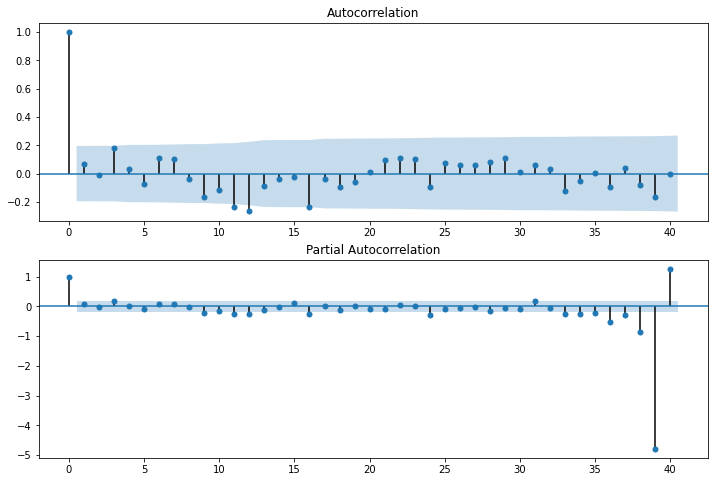

In [55]:
#plot the acf and pacf components
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax2)

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
model1=SARIMAX(df.Monthly_Rides,trend='n',order=(0,1,0),seasonal_order=(0,1,1,12))
results=model1.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Monthly_Rides   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -504.683
Date:                              Sun, 07 Mar 2021   AIC                           1013.365
Time:                                      13:25:31   BIC                           1018.596
Sample:                                  01-01-1960   HQIC                          1015.483
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6937      0.118     -5.867      0.000      -0.925      -0.462
sigma2      1185.56

In [58]:
model2=SARIMAX(df.Monthly_Rides,trend='n',order=(0,1,0),seasonal_order=(1,1,1,12))
result2=model2.fit()
print(result2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Monthly_Rides   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -501.340
Date:                              Sun, 07 Mar 2021   AIC                           1008.680
Time:                                      13:26:57   BIC                           1016.526
Sample:                                  01-01-1960   HQIC                          1011.856
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3236      0.186      1.739      0.082      -0.041       0.688
ma.S.L12      -0.99

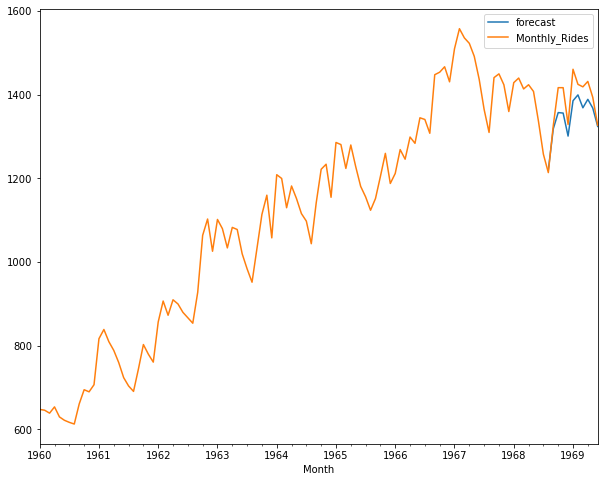

In [59]:
df['forecast']=result2.predict(start=103,end=114,dynamic=True)
df[['forecast','Monthly_Rides']].plot(figsize=(10,8))

In [67]:
forecasted_df=pd.DataFrame(df[['forecast','Monthly_Rides']].iloc[103:])

In [69]:
forecasted_df['difference']=forecasted_df.forecast-forecasted_df.Monthly_Rides
forecasted_df.head()

,forecast,Monthly_Rides,difference
Month,,,
1968-08-01,1220.249365,1214,6.249365
1968-09-01,1318.491061,1326,-7.508939
1968-10-01,1357.461265,1417,-59.538735
1968-11-01,1356.308119,1417,-60.691881
1968-12-01,1301.278585,1329,-27.721415


In [80]:
def error(x):
    mse=np.square(x.difference).mean()
    mae=np.absolute(x.difference).mean()
    mape=(100*np.sum((np.absolute(x.difference)/x.forecast)))/len(x.difference)
    print('Mean Squared Error {:.2f}'.format(mse))
    print('Mean absolute error {:.2f}'.format(mae))
    print('Mean absolute percentage error {:.2f}'.format(mape))


In [81]:
error(forecasted_df)

Mean Squared Error 1764.87
Mean absolute error 34.87
Mean absolute percentage error 2.56
